We will reproduce the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) here.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import hddm
import kabuki
print(hddm.__version__)

0.8.0


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Loading data

In [4]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.7/site-packages/hddm/__init__.py


In [5]:
!head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [6]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


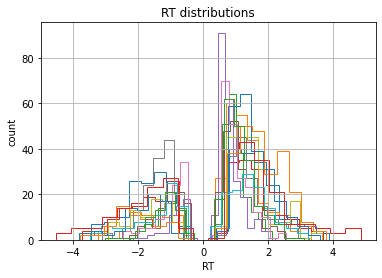

In [7]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

In [8]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model

In [9]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m.sample(2000, burn=20)

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 103.5 sec

In [10]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.97995,0.0976758,1.78603,1.91739,1.97654,2.04325,2.17345,0.00286582
a_std,0.341441,0.0862362,0.22156,0.282341,0.32479,0.380967,0.551865,0.00304375
a_subj.0,2.19858,0.06422,2.07398,2.15586,2.19804,2.24083,2.3265,0.00169335
a_subj.1,2.11457,0.0666153,1.98733,2.06861,2.11316,2.15642,2.25449,0.00221165


Plotting a
Plotting a_std
Plotting v
Plotting t


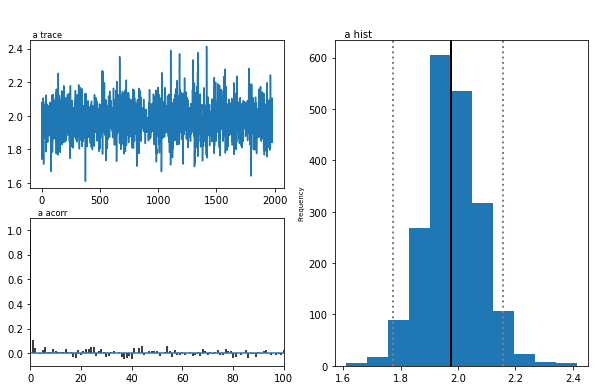

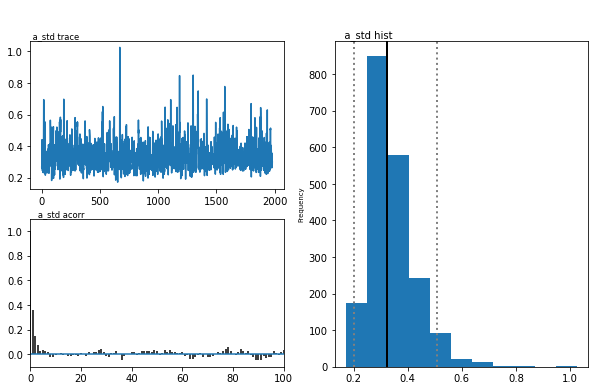

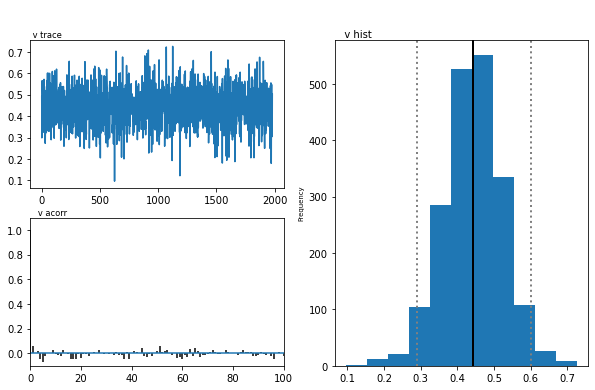

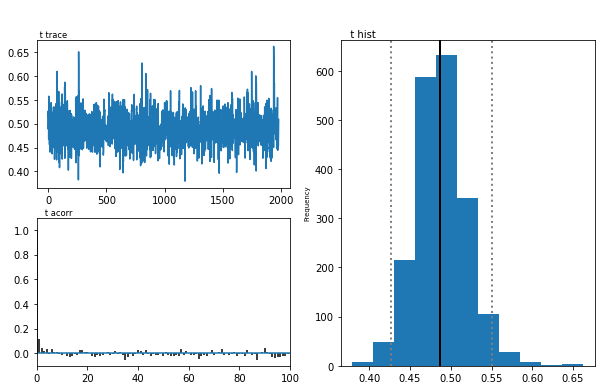

In [11]:
m.plot_posteriors(['a', 't', 'v', 'a_std'])

In [12]:
# models = []
# for i in range(5):
#     m = hddm.HDDM(data)
#     m.find_starting_values()
#     m.sample(5000, burn=20)
#     models.append(m)

# hddm.analyze.gelman_rubin(models)

you can also replace the for-loop with parallel processing:

In [13]:
# define a function to run model in parallel
def run_model(id):
    print('running model%i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm1'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m2 = hddm.HDDM(data)
    m2.find_starting_values()
    m2.sample(5000, burn=20,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m2.save(mname)
    
    return m2

In [14]:
# define a function to check the progress bar of the sampling
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [15]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

models_2 = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
270.688s elapsed

running model0
 [-----------------97%----------------  ] 4858 of 5000 complete in 268.4 sec
running model1
 [-----------------97%----------------  ] 4852 of 5000 complete in 268.6 sec
running model2
 [-----------------98%----------------- ] 4905 of 5000 complete in 268.6 sec
running model3
 [-----------------96%----------------  ] 4809 of 5000 complete in 268.0 sec



Running 4 chains used: 285.705365 seconds.


In [16]:
hddm.analyze.gelman_rubin(models_2)

{'a': 0.9999906745408154,
 'a_std': 1.0001527157252685,
 'a_subj.0': 1.0001547405565743,
 'a_subj.1': 1.0002492178680478,
 'a_subj.2': 1.0000633085034092,
 'a_subj.3': 1.0002103108392075,
 'a_subj.4': 1.0001836651351004,
 'a_subj.5': 1.0004799138089022,
 'a_subj.6': 1.0001860094806558,
 'a_subj.7': 1.000259183673985,
 'a_subj.8': 1.000361460387307,
 'a_subj.9': 1.0001386535306562,
 'a_subj.10': 1.0004214972225722,
 'a_subj.11': 1.0005672587174903,
 'a_subj.12': 1.0000030180926072,
 'a_subj.13': 1.0000133524716046,
 'v': 0.9999086597710439,
 'v_std': 1.0000060385535456,
 'v_subj.0': 1.0001794392385752,
 'v_subj.1': 0.9999745173205488,
 'v_subj.2': 1.0000046660486335,
 'v_subj.3': 1.000034988994638,
 'v_subj.4': 0.9999875194612341,
 'v_subj.5': 1.0000758655344482,
 'v_subj.6': 1.0000161393446547,
 'v_subj.7': 0.9999775141994918,
 'v_subj.8': 1.0000683430644999,
 'v_subj.9': 0.9999499908273908,
 'v_subj.10': 0.9999327348937492,
 'v_subj.11': 1.0000442787892756,
 'v_subj.12': 1.00040199274

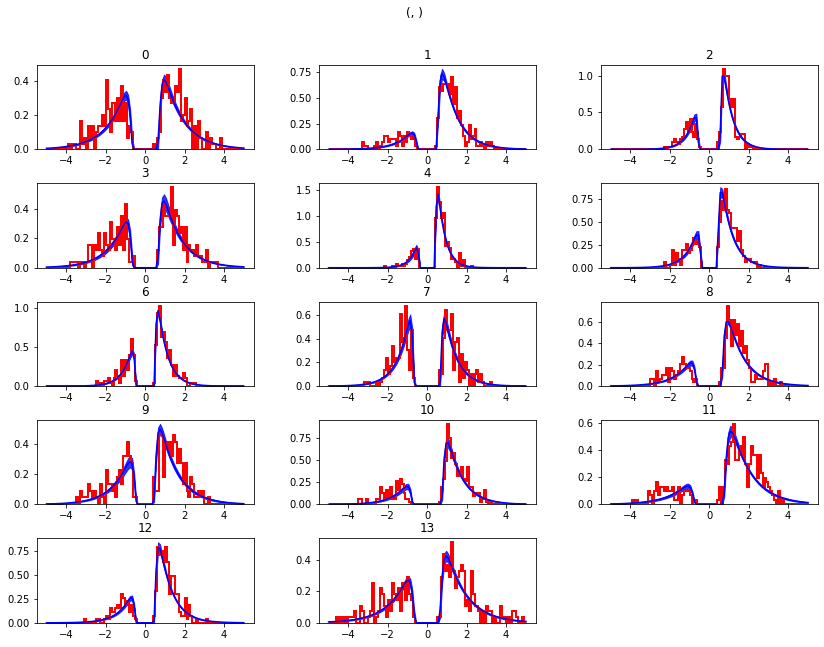

In [17]:
models_2[0].plot_posterior_predictive(figsize=(14, 10))

In [18]:
m_comb = kabuki.utils.concat_models(models_2) # combine four chains together

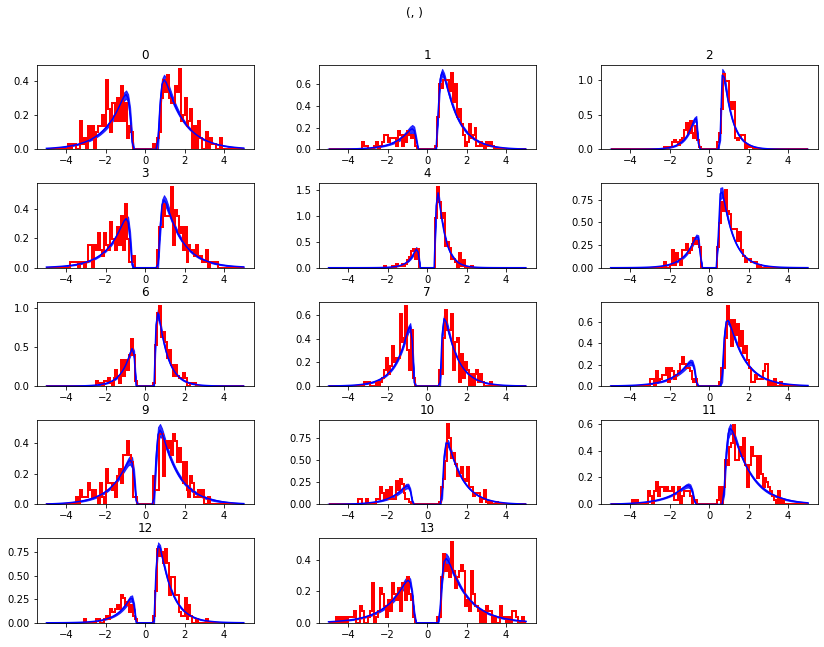

In [19]:
m_comb.plot_posterior_predictive(figsize=(14, 10))

#### Depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)
```

Here we defined a function for stimulus coding and used parallel processing

In [20]:
# define a function to run model in parallel
def run_m(id):
    print('running model (depends on stim) %i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(5000, burn=1000,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [21]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

m_stim_list = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
645.994s elapsed

running model (depends on stim) 0
 [-----------------100%-----------------] 5000 of 5000 complete in 639.8 sec
running model (depends on stim) 1
 [-----------------100%-----------------] 5000 of 5000 complete in 637.8 sec
running model (depends on stim) 2
 [-----------------100%-----------------] 5001 of 5000 complete in 629.7 sec
running model (depends on stim) 3
 [-----------------99%----------------- ] 4997 of 5000 complete in 642.8 sec



Running 4 chains used: 661.012224 seconds.


In [22]:
m_stim_all = kabuki.utils.concat_models(m_stim_list) 

Text(0.5, 1.0, 'Posterior of drift-rate group means')

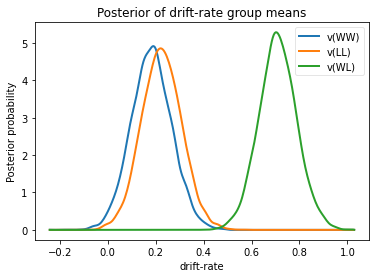

In [23]:
v_WW, v_LL, v_WL = m_stim_all.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
# plt.savefig('hddm_demo_fig_06.pdf')

In [24]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

P(WW > LL) =  0.358
P(LL > WL) =  0.0


In [25]:
print("Lumped model DIC: %f" % m.dic)
print("Stimulus model DIC: %f" % m_stim_all.dic)

Lumped model DIC: 10973.716653
Stimulus model DIC: 10786.741901


## Within-subject effects

In [26]:
from patsy import dmatrix
dmatrix("C(stim, Treatment('WL'))", data.head(10))

DesignMatrix with shape (10, 3)
  Intercept  C(stim, Treatment('WL'))[T.LL]  C(stim, Treatment('WL'))[T.WW]
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('WL'))" (columns 1:3)

The original code in the tutorial was:

```
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")
m_within_subj.sample(5000, burn=200)
```

Here we used four chains for parallel processing

In [27]:
# define a function to run model in parallel
def run_m_reg(id):
    print('running within-subj model %i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm_reg'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")
    m.find_starting_values()
    m.sample(5000, burn=1000,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [28]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m_reg, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

m_reg_list = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
1336.754s elapsed

running within-subj model 0
Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]
 [-----------------100%-----------------] 5001 of 5000 complete in 1332.6 secWARNING: Will not save custom link functions.

running within-subj model 1
Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]
 [-----------------99%----------------- ] 4966 of 5000 complete in 1333.8 sec
running within-subj model 2
Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]
 [-----------------100%-----------------] 5000 of 5000 complete in 1330.7 secWARNING: Will not save custom link functions.

running within-subj model 3
Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]
 [-----------------99%----------------- ] 4988 of 5000 compl


Running 4 chains used: 1351.776549 seconds.


In [29]:
m_reg_all = kabuki.utils.concat_models(m_reg_list) 

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

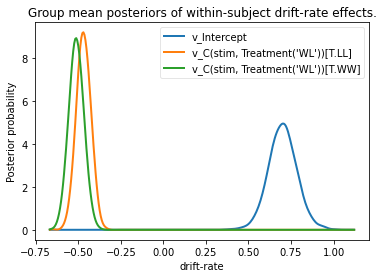

In [30]:
v_WL, v_LL, v_WW = m_reg_all.nodes_db.loc[["v_Intercept",
                                              "v_C(stim, Treatment('WL'))[T.LL]",
                                              "v_C(stim, Treatment('WL'))[T.WW]"], 'node']
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

## Fitting regression models

In [31]:
m_reg = hddm.HDDMRegressor(data[data.dbs == 0],
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'stim'})
m_reg.sample(5000, burn=200)

Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"]
 [-----------------100%-----------------] 5001 of 5000 complete in 2037.0 sec

P(a_theta < 0) =  0.049791666666666665


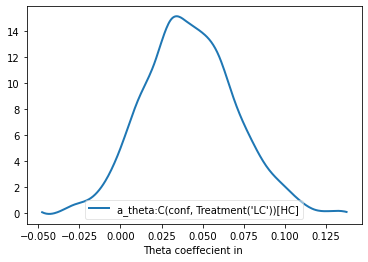

In [32]:
theta = m_reg.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=20)
plt.xlabel('Theta coeffecient in ')
print("P(a_theta < 0) = ", (theta.trace() < 0).mean())

In [33]:
m_reg_off = hddm.HDDMRegressor(data[data.dbs == 1],
                               "a ~ theta:C(conf, Treatment('LC'))",
                               depends_on={'v': 'stim'})
m_reg_off.sample(5000, burn=200)

Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"]
 [-----------------100%-----------------] 5001 of 5000 complete in 1892.2 sec

P(a_theta > 0) =  0.04791666666666667


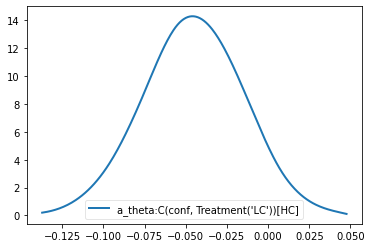

In [34]:
theta = m_reg_off.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=10)
print("P(a_theta > 0) = ", (theta.trace() > 0).mean())

## Dealing witih outliers

In [35]:
outlier_data, params = hddm.generate.gen_rand_data(params={'a': 2, 't': .4, 'v': .5},
                                                   size=200, n_fast_outliers=10)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
m_no_outlier = hddm.HDDM(outlier_data)
m_no_outlier.sample(2000, burn=50)

 [-----------------100%-----------------] 2000 of 2000 complete in 7.2 sec

Text(0, 0.5, 'Probability density')

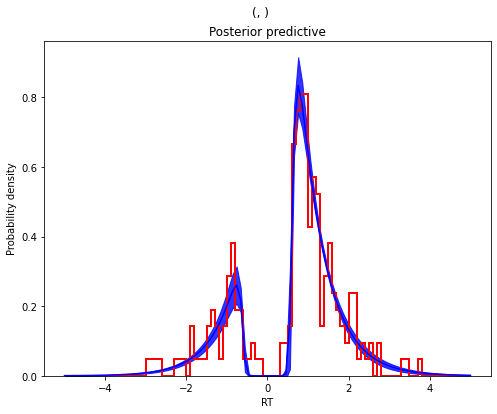

In [37]:
m_no_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_10.pdf')

In [38]:
m_outlier = hddm.HDDM(outlier_data, p_outlier=.05)
m_outlier.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 7.1 sec

Text(0, 0.5, 'Probability density')

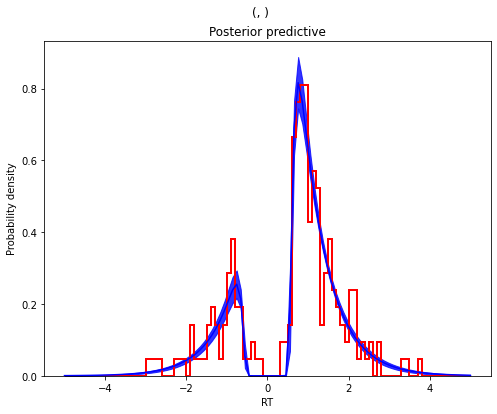

In [39]:
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_11.pdf')